based on https://jhat.readthedocs.io/en/latest/examples/plot_b_nircam.html

In [1]:
%matplotlib inline


# JWST NIRCAM

Aligning JWST/NIRCAM images with JHAT.


An example NIRCam Dataset is downloaded, and then a series of
alignment methods are used. For more information on the
key parameters used for alignment see 
`params:Useful Parameters`.



In [2]:
import sys,os,glob
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.visualization import (simple_norm,LinearStretch)
from astroquery.gaia import Gaia

import jhat
from jhat import jwst_photclass,st_wcs_align



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


## Relative Alignment

**Download some Data**

For this example we download 2 JWST NIRCam images from MAST. They're
the same field but different filters. Note that 
the code will also work for level 3 data images.



In [17]:
obs_table1 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f200w')
data_products_by_obs = Observations.get_product_list(obs_table1)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcb1']

In [18]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617603           JWST            image ...     PUBLIC           2   F200W

In [19]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                         Local Path                                          ...
                                           str92                                             ...
-------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcb1/jw02107041001_02101_00001_nrcb1_cal.fits ...

In [20]:
obs_table2 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f360m')
data_products_by_obs = Observations.get_product_list(obs_table2)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcblong']

In [21]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617252           JWST            image ...     PUBLIC           2   F360M

In [22]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                            Local Path                                             ...
                                              str98                                                ...
-------------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcblong/jw02107041001_02101_00001_nrcblong_cal.fits ...

**Examine the Reference Image**




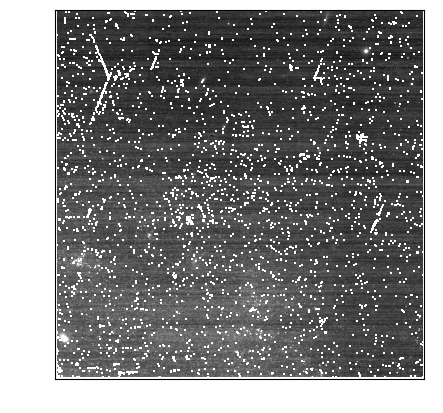

In [3]:
ref_image = glob.glob('jwstred_temp/jw02107041001_02101_00001_nrcb1_cal.fits')[0]

ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI',1].data
norm1 = simple_norm(ref_data,stretch='linear',min_cut=-.5,max_cut=3)

plt.imshow(ref_data, origin='lower',
                      norm=norm1,cmap='gray')
plt.gca().tick_params(labelcolor='none',axis='both',color='none')
plt.show()

**Zoom in to see the offset**

Here add an artificial offset to the wcs, and then we see the 
same star in both images at the same ra/dec
location, demonstrating a large offset between
the images.  



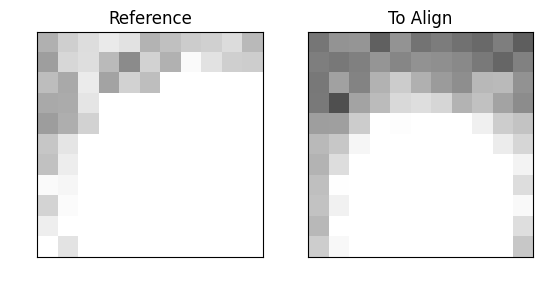

In [24]:
star_location = SkyCoord('23:09:41.0532','-43:26:41.128',unit=(u.hourangle,u.deg))
align_image = glob.glob('jwstred_temp/jw02107041001_02101_00001_nrcblong_cal.fits')[0]
align_fits = fits.open(align_image)
align_fits['SCI',1].header['CRPIX1']+=1
align_fits['SCI',1].header['CRPIX2']+=1
align_fits.writeto(align_image,overwrite=True)

align_data = fits.open(align_image)['SCI',1].data
ref_y,ref_x = skycoord_to_pixel(star_location,wcs.WCS(ref_fits['SCI',1],ref_fits))
align_y,align_x = skycoord_to_pixel(star_location,wcs.WCS(align_fits['SCI',1],align_fits))

ref_cutout = extract_array(ref_data,(11,11),(ref_x,ref_y))
align_cutout = extract_array(align_data,(11,11),(align_x,align_y))
norm1 = simple_norm(ref_cutout,stretch='linear',min_cut=-.5,max_cut=3)
norm2 = simple_norm(align_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,2)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[0].tick_params(labelcolor='none',axis='both',color='none')
axes[1].tick_params(labelcolor='none',axis='both',color='none')

plt.show()

**Create a Photometric Catalog for Relative Alignment**

We choose one of the images to be the reference image, and then 
create a catalog that we will use to align the other image.



In [10]:
ref_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits')[0]

In [11]:
jwst_phot = jwst_photclass()
jwst_phot.run_phot(imagename=ref_image,photfilename='auto',overwrite=True,ee_radius=80)
ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

0 jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.phot.txt


2024-09-13 09:33:59,039 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-13 09:33:59,351 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-13 09:33:59,365 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-13 09:33:59,366 - stpipe - INFO - Instrument: NIRCAM
2024-09-13 09:33:59,367 - stpipe - INFO - Detector: NRCA4
2024-09-13 09:33:59,367 - stpipe - INFO - Filter: F090W
2024-09-13 09:33:59,368 - stpipe - INFO - Pupil: CLEAR
2024-09-13 09:33:59,369 - stpipe - INFO - Subarray: FULL
2024-09-13 09:33:59,411 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.36200000000000004
aper_sum_7.5px annulus_median_7.5px aper_bkg_7.5px ...   x_idl      y_idl   
-------------- -------------------- -------------- ... ---------- ----------
   1282.769968             1.445329     254.050273 ... -18.643959 -31.473312
    272.537112             1.364692      239.87646 ...  -15.31883 -31.419365
   1104.006973             1.521235     267.392532 ...  -6.312187 -31.519364
    1623.61574             2.993575     526.190814 ...   7.933129 -31.537068
   2906.632796             3.634204     638.796214 ...  13.861517 -31.539625
   1536.176802             4.759752     836.637639 ...  16.211523 -31.581025
   2008.532597             3.631472     638.316078 ...   20.54461  -31.55208
   1399.745898             6.867782    1207.173183 ...    23.5698 -31.528641
   1090.518536             5.584095     981.535093 ...  24.234927 -31.568573
   1223.712559             4.554184      800.50433 ...  30.066456 -31.555231
           ...                  ...            ... 

**Align the second image**

The plots outputted here show the various steps used by jhat to
determine the true matching sources in the image, and the
subsequent correction needed for optimal alignment.



In [12]:
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.fits')[0]

0 ./jwstred_temp/jw01334001001_02101_00002_nrca4.phot.txt


2024-09-13 09:37:05,486 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-13 09:37:05,805 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-13 09:37:05,823 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-13 09:37:05,824 - stpipe - INFO - Instrument: NIRCAM
2024-09-13 09:37:05,826 - stpipe - INFO - Detector: NRCA4
2024-09-13 09:37:05,826 - stpipe - INFO - Filter: F090W
2024-09-13 09:37:05,827 - stpipe - INFO - Pupil: CLEAR
2024-09-13 09:37:05,828 - stpipe - INFO - Subarray: FULL
2024-09-13 09:37:05,862 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.2172
dmag 1.0
sharpness 0.9
roundness1 0.7
mag 24
x 2008
y 2008
reffile_d2d 0.2
*** Note: close plot to continue!


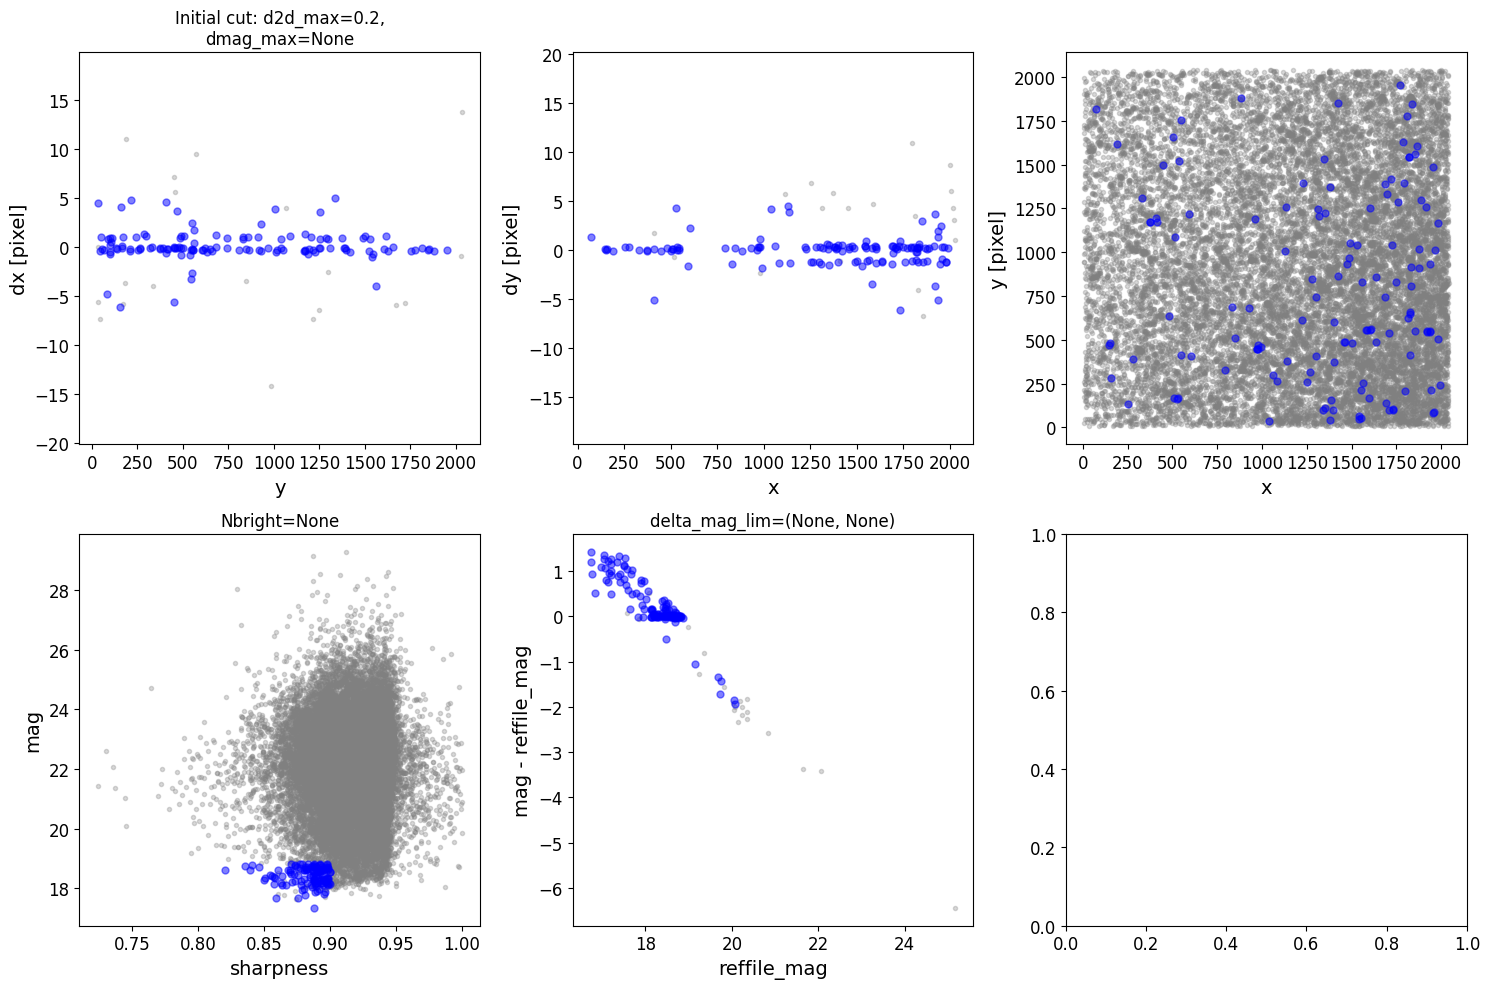

    slope  intercept    maxval  index  d_bestguess  fwhm  multimax
-0.000098        0.1 60.575986    331    -0.244798  0.62     False
d_rot_tmp 0.5552015869387816
Keeping 83 out of 83, skippin 0 because of null values in columns d_rot_tmp
median: -0.262339
75.000000 percentile cut: max residual for cut: 0.198108
__tmp_residuals 0.19810830355685785
median: -0.246607
i:00 mean:-0.246607(0.013472) stdev:0.105218(0.009449) X2norm:0.99 Nchanged:0 Ngood:62 Nclip:21

mean: -0.255196
i:01 mean:-0.255196(0.015615) stdev:0.131576(0.010965) X2norm:1.00 Nchanged:10 Ngood:72 Nclip:11

mean: -0.246061
i:02 mean:-0.246061(0.016505) stdev:0.141016(0.011591) X2norm:1.00 Nchanged:2 Ngood:74 Nclip:9

mean: -0.246061
i:03 mean:-0.246061(0.016505) stdev:0.141016(0.011591) X2norm:1.00 Nchanged:0 Ngood:74 Nclip:9


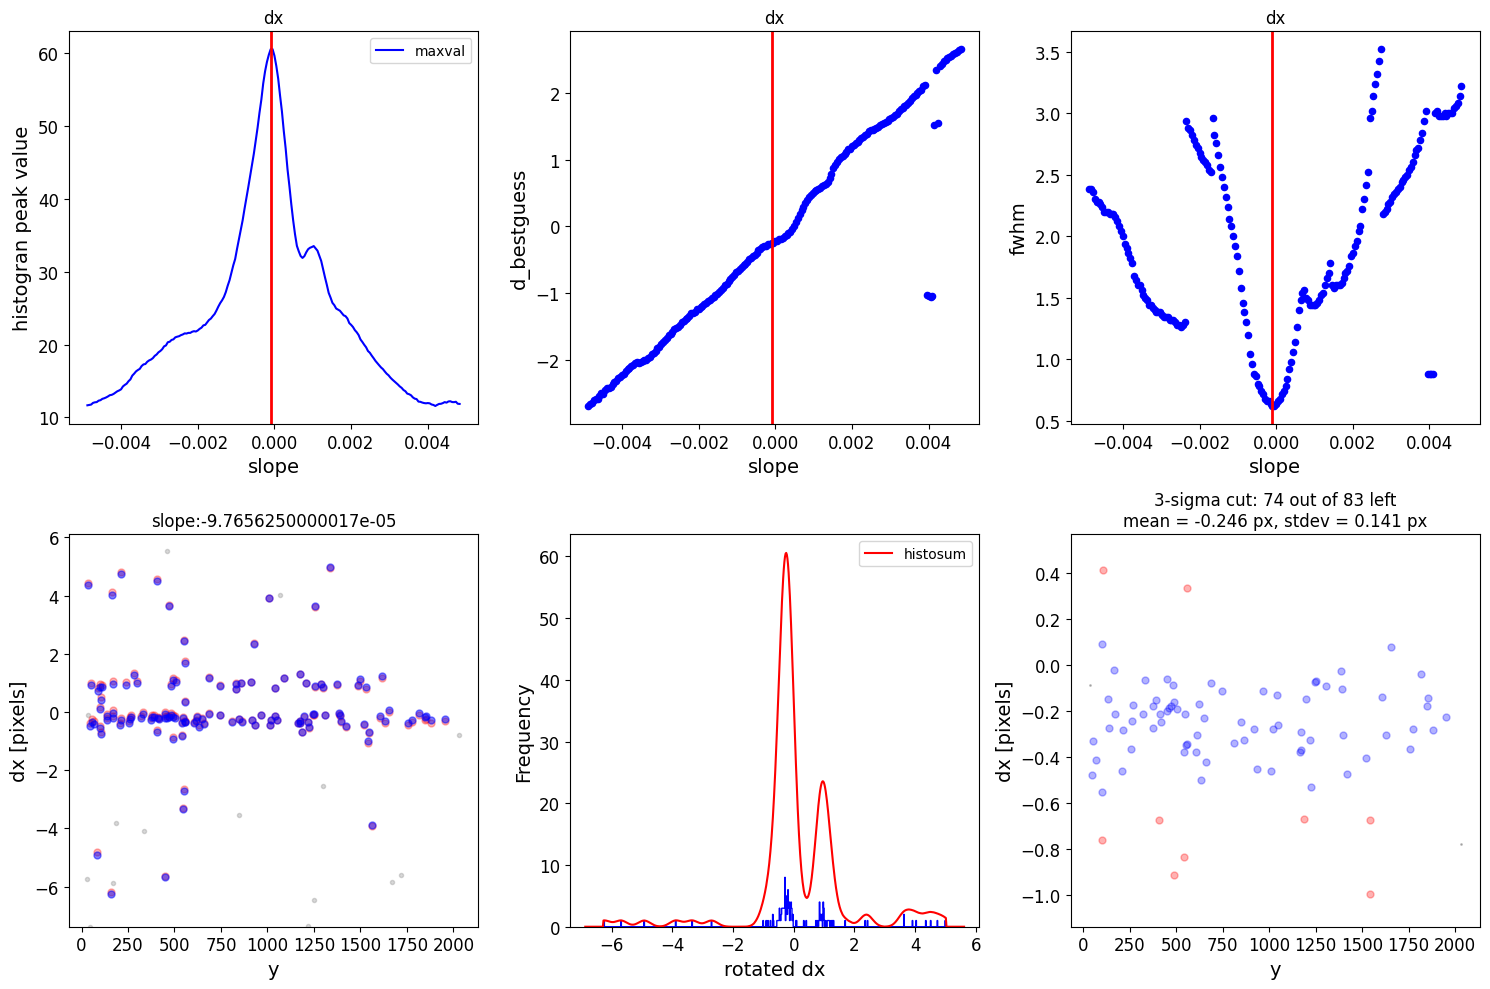

   slope  intercept    maxval  index  d_bestguess  fwhm  multimax
0.000146      -0.15 36.019325    291     0.161306  0.62     False
d_rot_tmp 0.9613062091257618
Keeping 47 out of 47, skippin 0 because of null values in columns d_rot_tmp
median: 0.140086
75.000000 percentile cut: max residual for cut: 0.179913
__tmp_residuals 0.17991348478884162
median: 0.139554
i:00 mean:0.139554(0.016754) stdev:0.097694(0.011677) X2norm:0.99 Nchanged:0 Ngood:35 Nclip:12

mean: 0.162197
i:01 mean:0.162197(0.020169) stdev:0.129142(0.014091) X2norm:1.00 Nchanged:7 Ngood:42 Nclip:5

mean: 0.166399
i:02 mean:0.166399(0.022572) stdev:0.149726(0.015783) X2norm:1.00 Nchanged:3 Ngood:45 Nclip:2

mean: 0.166399
i:03 mean:0.166399(0.022572) stdev:0.149726(0.015783) X2norm:1.00 Nchanged:0 Ngood:45 Nclip:2


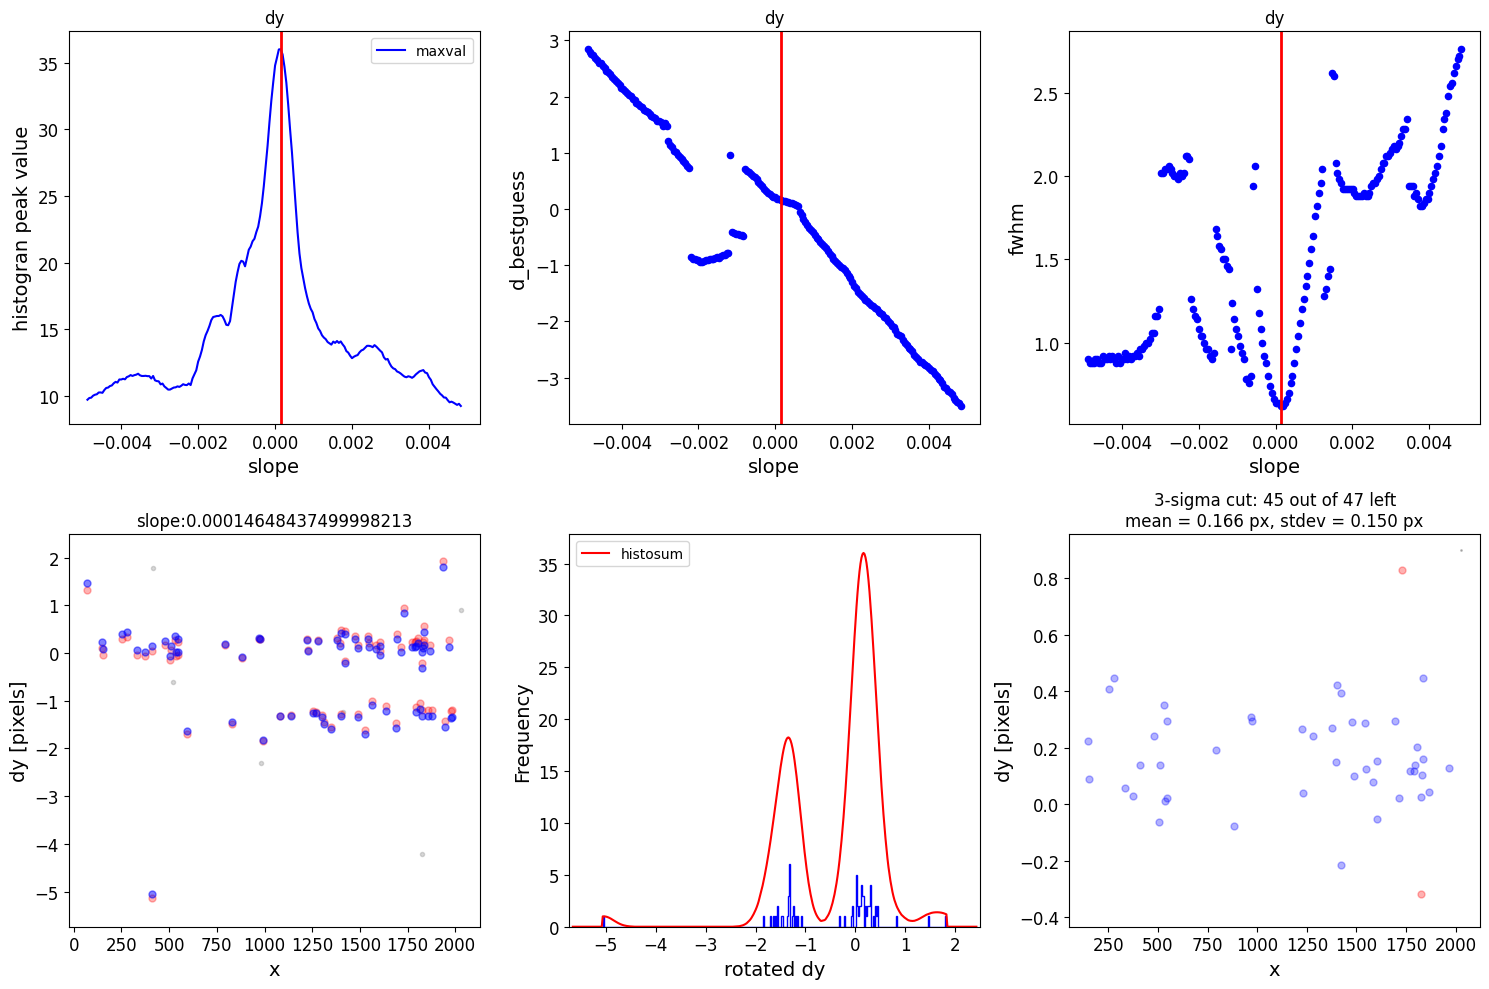

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-09-13 09:37:42,604 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-09-13 09:37:43,177 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01334001001_02101_00002_nrca4_cal.fits>],).
2024-09-13 09:37:43,185 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp/jw01334001001_02101_00002_nrca4_jhat.fits
  output_dir: ./jwstred_temp
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_gaia: Fals

replacing SIP ./jwstred_temp/jw01334001001_02101_00002_nrca4_jhat.fits


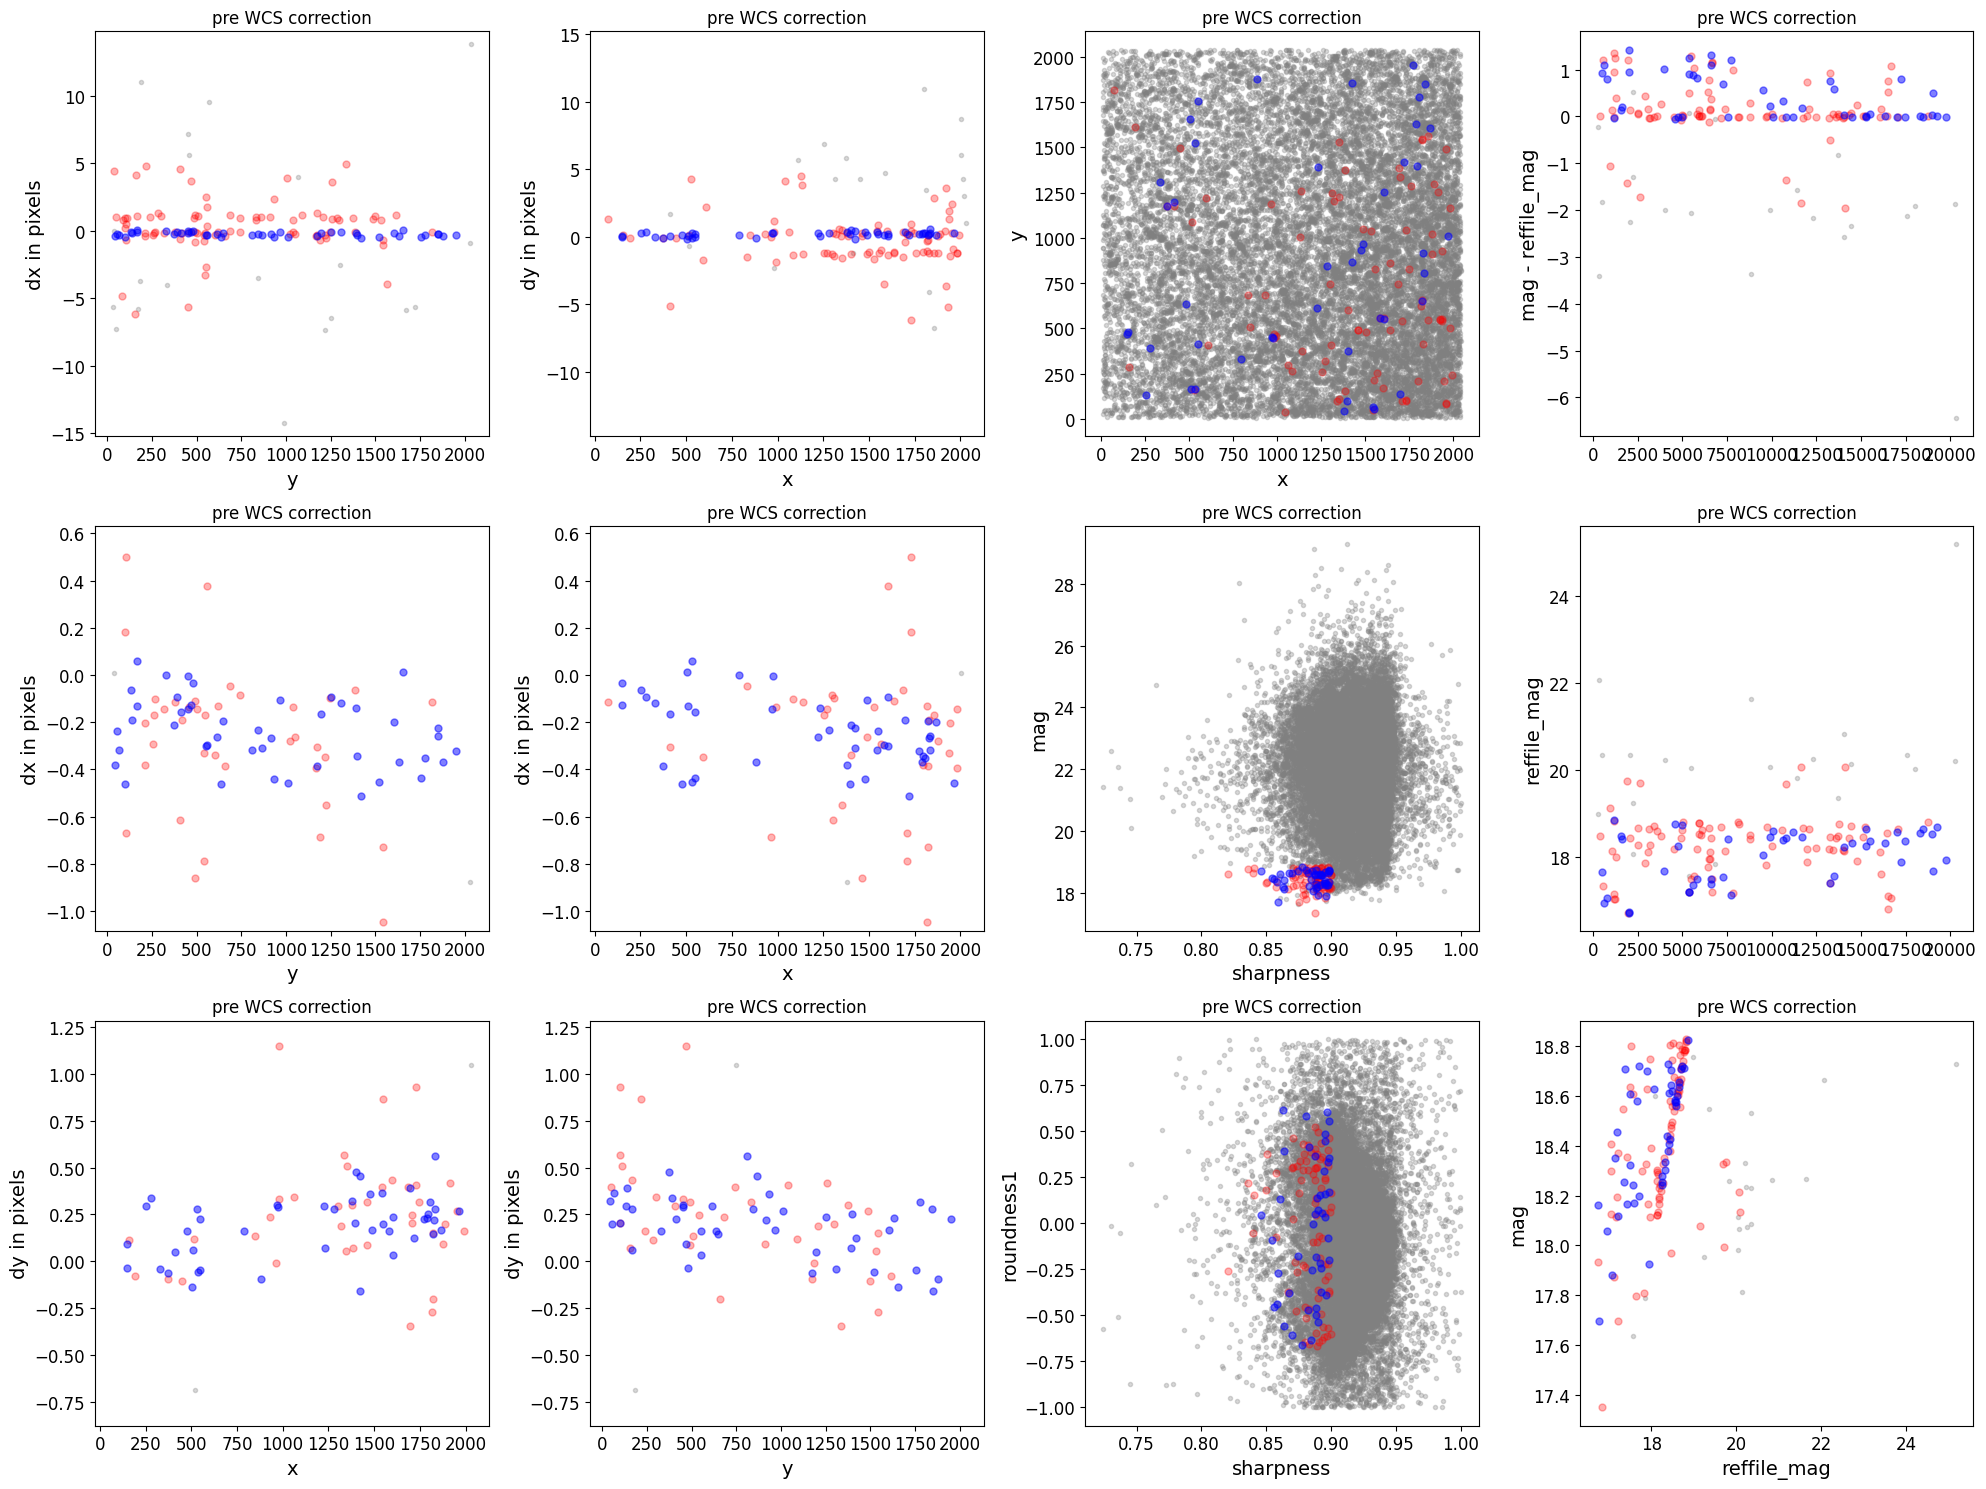

./jwstred_temp/jw01334001001_02101_00002_nrca4_jhat.fits


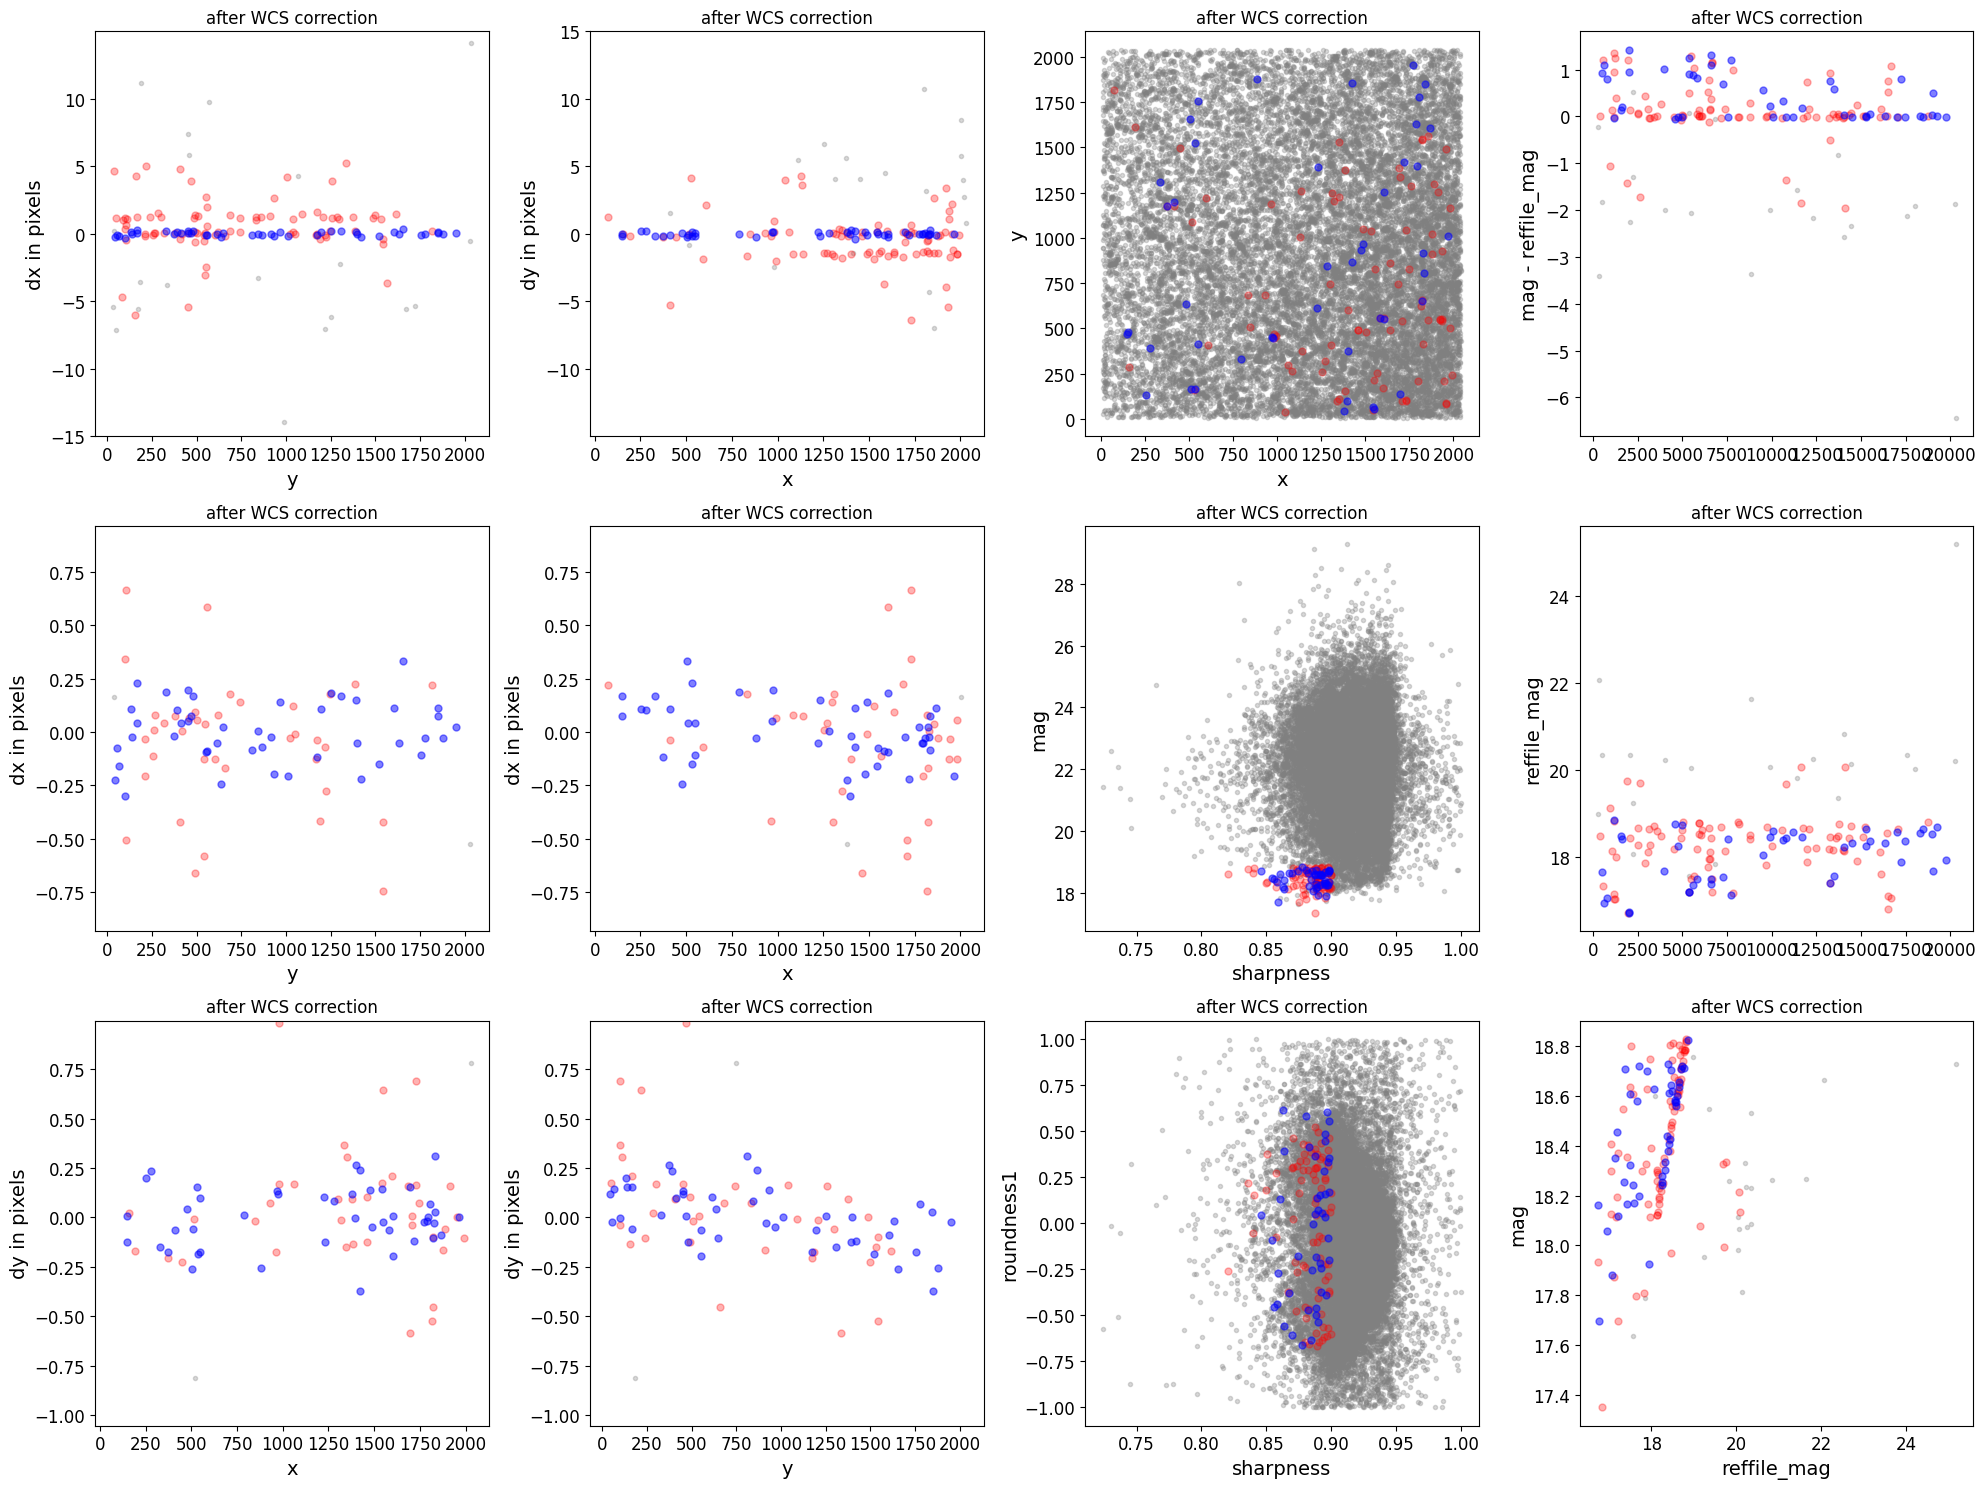

*** Note: close plots to continue!


0

In [14]:
wcs_align = st_wcs_align()


wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.2,
          showplots=2,
          find_stars_threshold=3,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 5,
              dmag_max=1.0,
              Nbright=150,
              objmag_lim =(14,24))

**Check the Output**

The reference image has not changed, but let's read in the newly
aligned image and compare with the original. 
subsequent correction needed for optimal alignment.



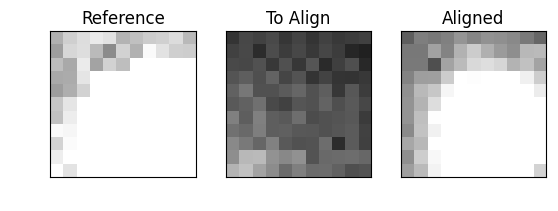

In [7]:
aligned_image = os.path.join('jwstred_temp',os.path.basename(align_image).replace('cal.fits','jhat.fits'))
aligned_fits = fits.open(aligned_image)
aligned_data = fits.open(aligned_image)['SCI',1].data
aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

## Align to Catalog

You can also align each image to the Gaia DR3 catalog, or you
could replace the catalog created in step one with your own
catalog of the field. 



In [6]:
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits')[0]

telescope set to jwst

### Doing photometry on jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits
True ./jwstred_temp/jw01334001001_02101_00001_nrca4.phot.txt
photometry catalog filename: ./jwstred_temp/jw01334001001_02101_00001_nrca4.phot.txt
photcat ./jwstred_temp/jw01334001001_02101_00001_nrca4.phot.txt already exists, but recreating it since overwrite=True
Instrument: NIRCAM, aperture:NRCA4_FULL
Applying Pixel Area Map
Finding stars --- Detector: NRCA4, Filter: F090W
FWHM for the filter F090W: 1.103 px
Background and rms using MMMBackground and MADStdBackgroundRMS: 0.7373621463775635 0.5657960341789743


2024-09-17 20:33:28,107 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.



Number of sources found in the image: 20902
-------------------------------------



2024-09-17 20:33:28,334 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-17 20:33:28,344 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-17 20:33:28,345 - stpipe - INFO - Instrument: NIRCAM
2024-09-17 20:33:28,346 - stpipe - INFO - Detector: NRCA4
2024-09-17 20:33:28,346 - stpipe - INFO - Filter: F090W
2024-09-17 20:33:28,347 - stpipe - INFO - Pupil: CLEAR
2024-09-17 20:33:28,347 - stpipe - INFO - Subarray: FULL
2024-09-17 20:33:28,370 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


radii:[4.162]pixels radius_sky_in:7.480000019073486 radius_sky_out:9.25100040435791  radius_for_mag:[4.162]
Performing aperture photometry for radius r = 4.1620001792907715 px
Time Elapsed: 15.934867789999771
20329 objects left after removing entries with NaNs in mag or dmag column
dmag 0.36200000000000004
SNR_min cut: 20247 objects left after removing entries dmag>0.36200000000000004 (SNR<3)
20247 out of 20329 entries remain in photometry table
Saving ./jwstred_temp/jw01334001001_02101_00001_nrca4.phot.txt
########### !!!!!!!!!!  INITIAL CUT on image photometry cat: starting with 20329 objects
dmag_max =0.1 CUT:
dmag 0.1
19894 left
SHARPNESS =(0.3, 0.9) CUT:
sharpness 0.9
5243 left
roundness1=(-0.7, 0.7) CUT:
roundness1 0.7
4675 left
objmag_lim=(15, 23) CUT:
mag 23
3367 left
3367 of image photometry objects pass initial cuts #1, 16962 cut
Getting Gaia and matching it: ra=259.2617800995965 dec=43.123996160509805 radius=0.01875105821331057 deg
RA/Dec columns in reference catalog:  auto 

2024-09-17 20:33:53,777 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 2670
### NO propoer motion correction!!!
Number of stars after removing nan's: 2670
########### !!!!!!!!!!  INITIAL CUT on reference catalog: starting with 2670 objects
2670 of image photometry objects pass initial cuts #1, 0 cut
Matching reference catalog Gaia
Using 3367 image objects that are in x_idl=[-31.20,31.65] and y_idl=[-31.53,31.40] range
x 2008
y 2008
Keeping 709 out of 2670 catalog objects within x=40.0-2008 and y=40.0-2008
Keeping 709  after removing NaNs from ra/dec
!! Matching 3367 image objects to 709 refcat objects!
########### !!!!!!!!!!  INITIAL CUT on matched cat: starting with 3367 objects
d2d =0.25 CUT using gaia_d2d:
gaia_d2d 0.25
105 left
105 of image photometry objects pass initial cuts #1, 3262 cut
dx median: -0.2193942860678817
dy median: 0.5339771735948489
*** Note: close plot to continue!


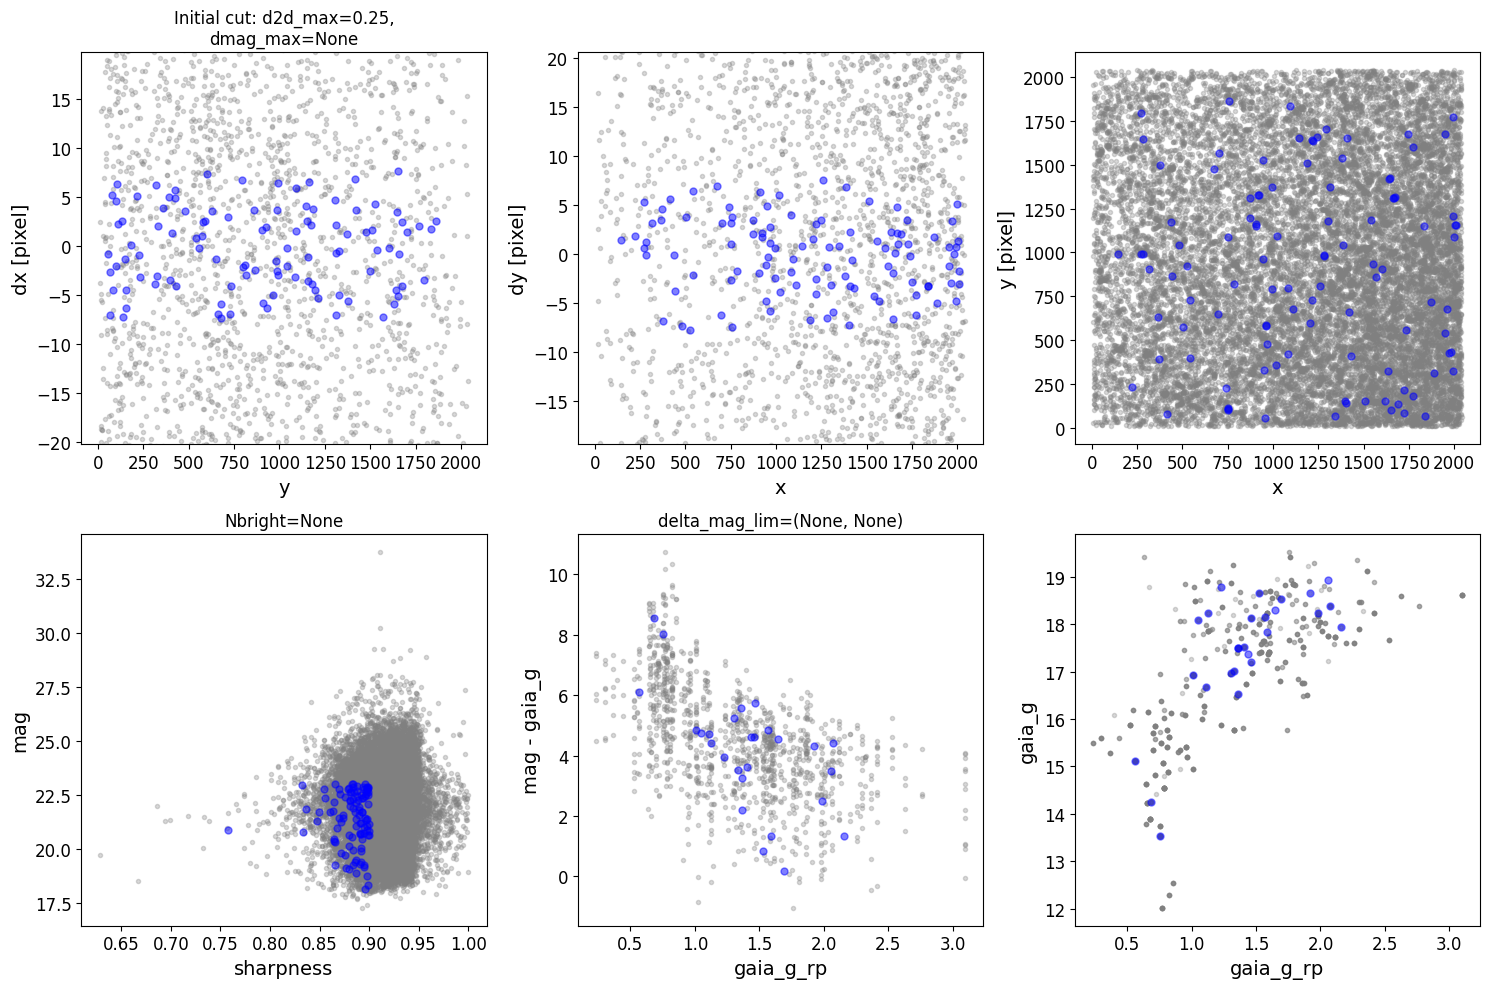

### Doing histogram cut for dx, slope_min:-0.004883 slope_max:0.004883 slope_stepsize:0.000049
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dx versus y
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=0.02, gaussian_sigma(bins)=10.0, windowsize(bins)=61 halfwindowsize(bins)=31
####BEST:
   slope  intercept   maxval  index  d_bestguess  fwhm  multimax
0.002197      -2.25 8.836575    381    -1.447282  0.58     False
Setting rough_cut_px=1.449999999999969. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp -0.6472817452942656

rough_cut_px=0.8 pixels removes 91 from 105 entries
Keeping 14 out of 14, skippin 0 because of null values in columns d_rot_tmp
median: -1.496225
75.000000 percentile cut: max residual for cut: 0.503612
__tmp_residuals 0.5036122101988176
median: -1.457360
i:00 mean:-1.457360(0.039753) stdev:0.119258(0.026667) X2norm:0.95 N

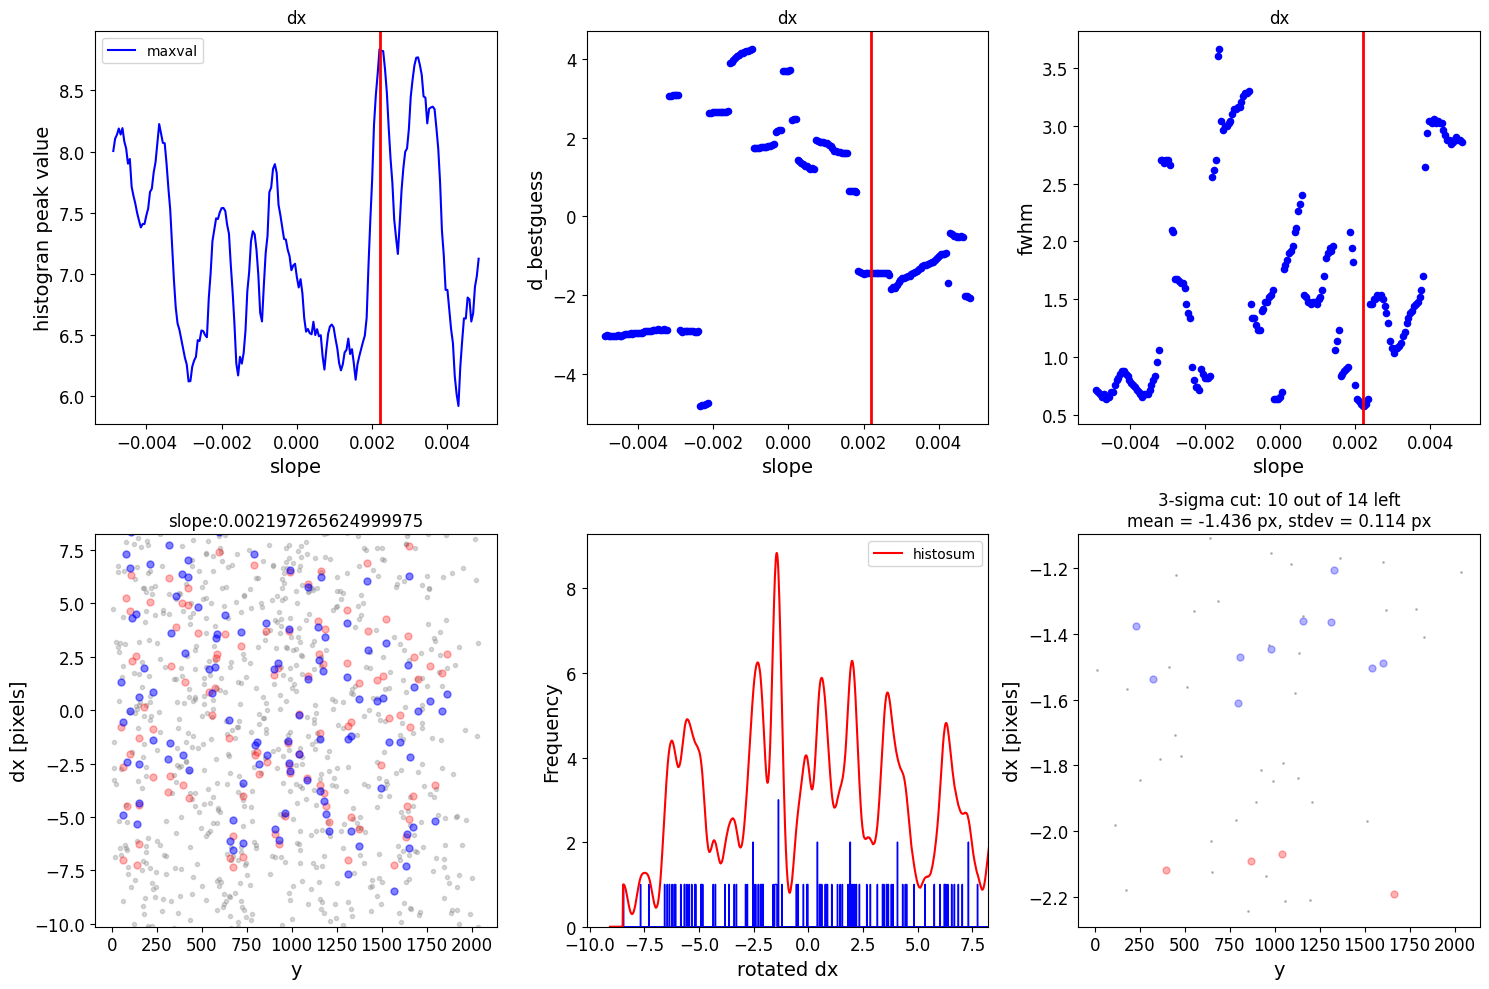

### Doing histogram cut for dy, slope_min:-0.004883 slope_max:0.004883 slope_stepsize:0.000049
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dy versus x
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=0.02, gaussian_sigma(bins)=10.0, windowsize(bins)=61 halfwindowsize(bins)=31
####BEST:
   slope  intercept   maxval  index  d_bestguess  fwhm  multimax
0.000244      -0.25 3.513538    450     1.939587  0.56     False
Setting rough_cut_px=1.3999999999999702. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp 2.7395874194723726

rough_cut_px=0.8 pixels removes 6 from 10 entries
Keeping 4 out of 4, skippin 0 because of null values in columns d_rot_tmp
median: 1.983881
75.000000 percentile cut: max residual for cut: 0.079502
__tmp_residuals 0.07950210416486742
median: 2.007999
i:00 mean:2.007999(0.027225) stdev:0.038502(0.015719) X2norm:0.79 Nchange

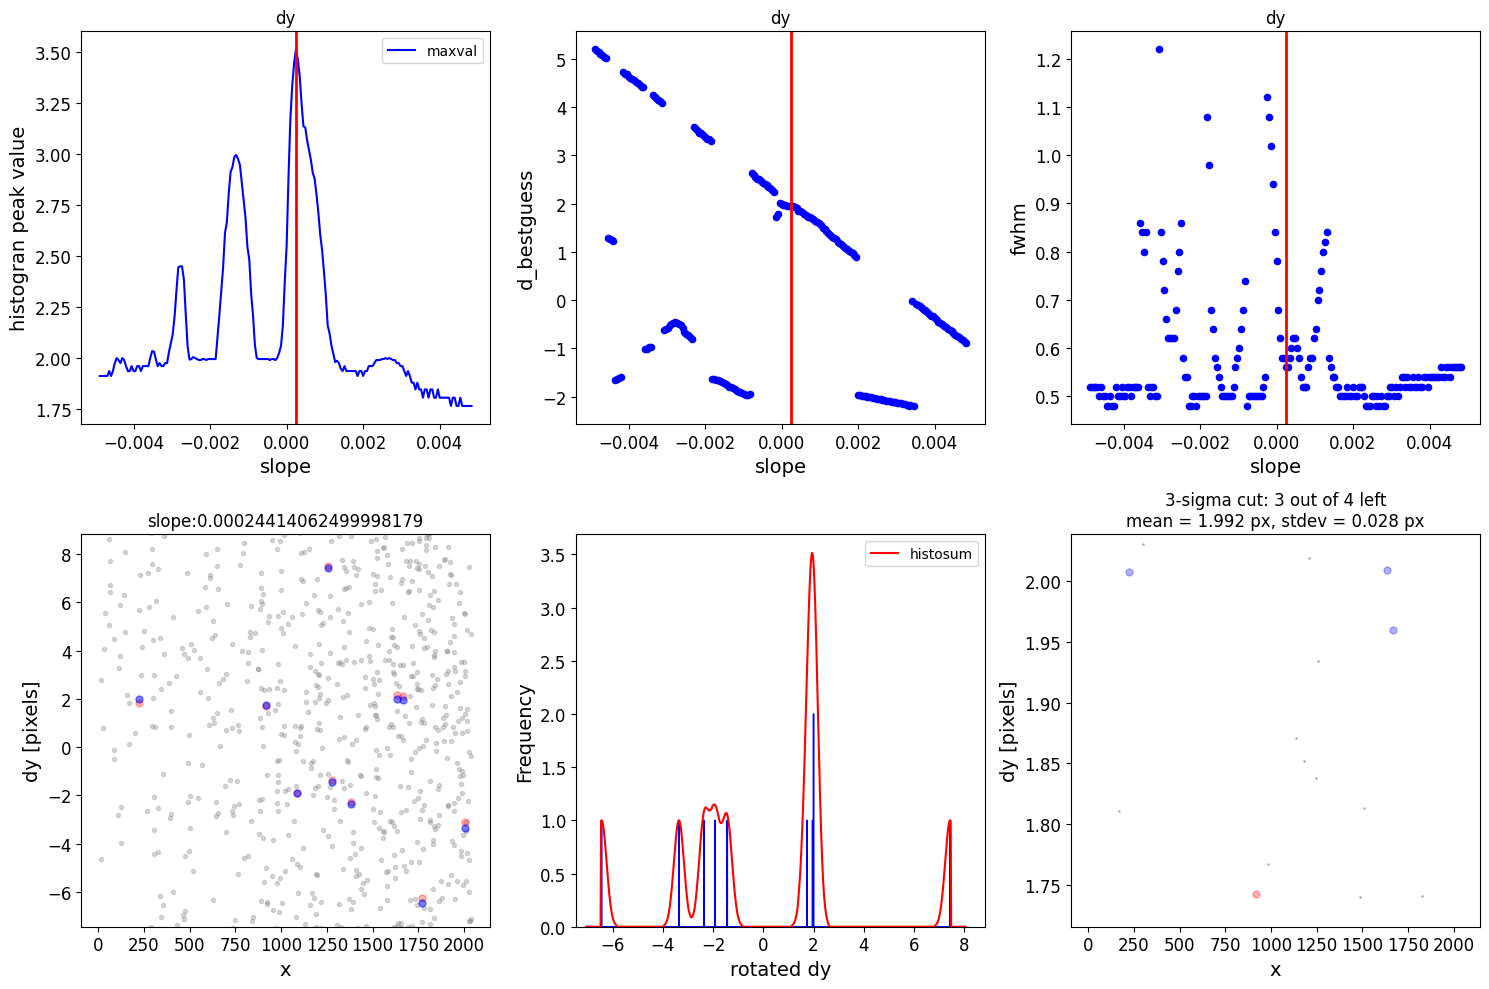

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-09-17 20:34:00,533 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.


Setting output directory for jw01334001001_02101_00001_nrca4_jhat.fits file to ./jwstred_temp
3 matches are passed to tweakreg rshift fitting
Fitting tweakreg fitgeometry=rshift to xy=x,y to ra,dec=gaia_ra,gaia_dec


2024-09-17 20:34:01,268 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01334001001_02101_00001_nrca4_cal.fits>],).
2024-09-17 20:34:01,274 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp/jw01334001001_02101_00001_nrca4_jhat.fits
  output_dir: ./jwstred_temp
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_gaia: False
  gaia_catalog: GAIADR2
  min_gaia: 30
  save_gaia_catalog: False
  telescope: jwst


replacing SIP ./jwstred_temp/jw01334001001_02101_00001_nrca4_jhat.fits


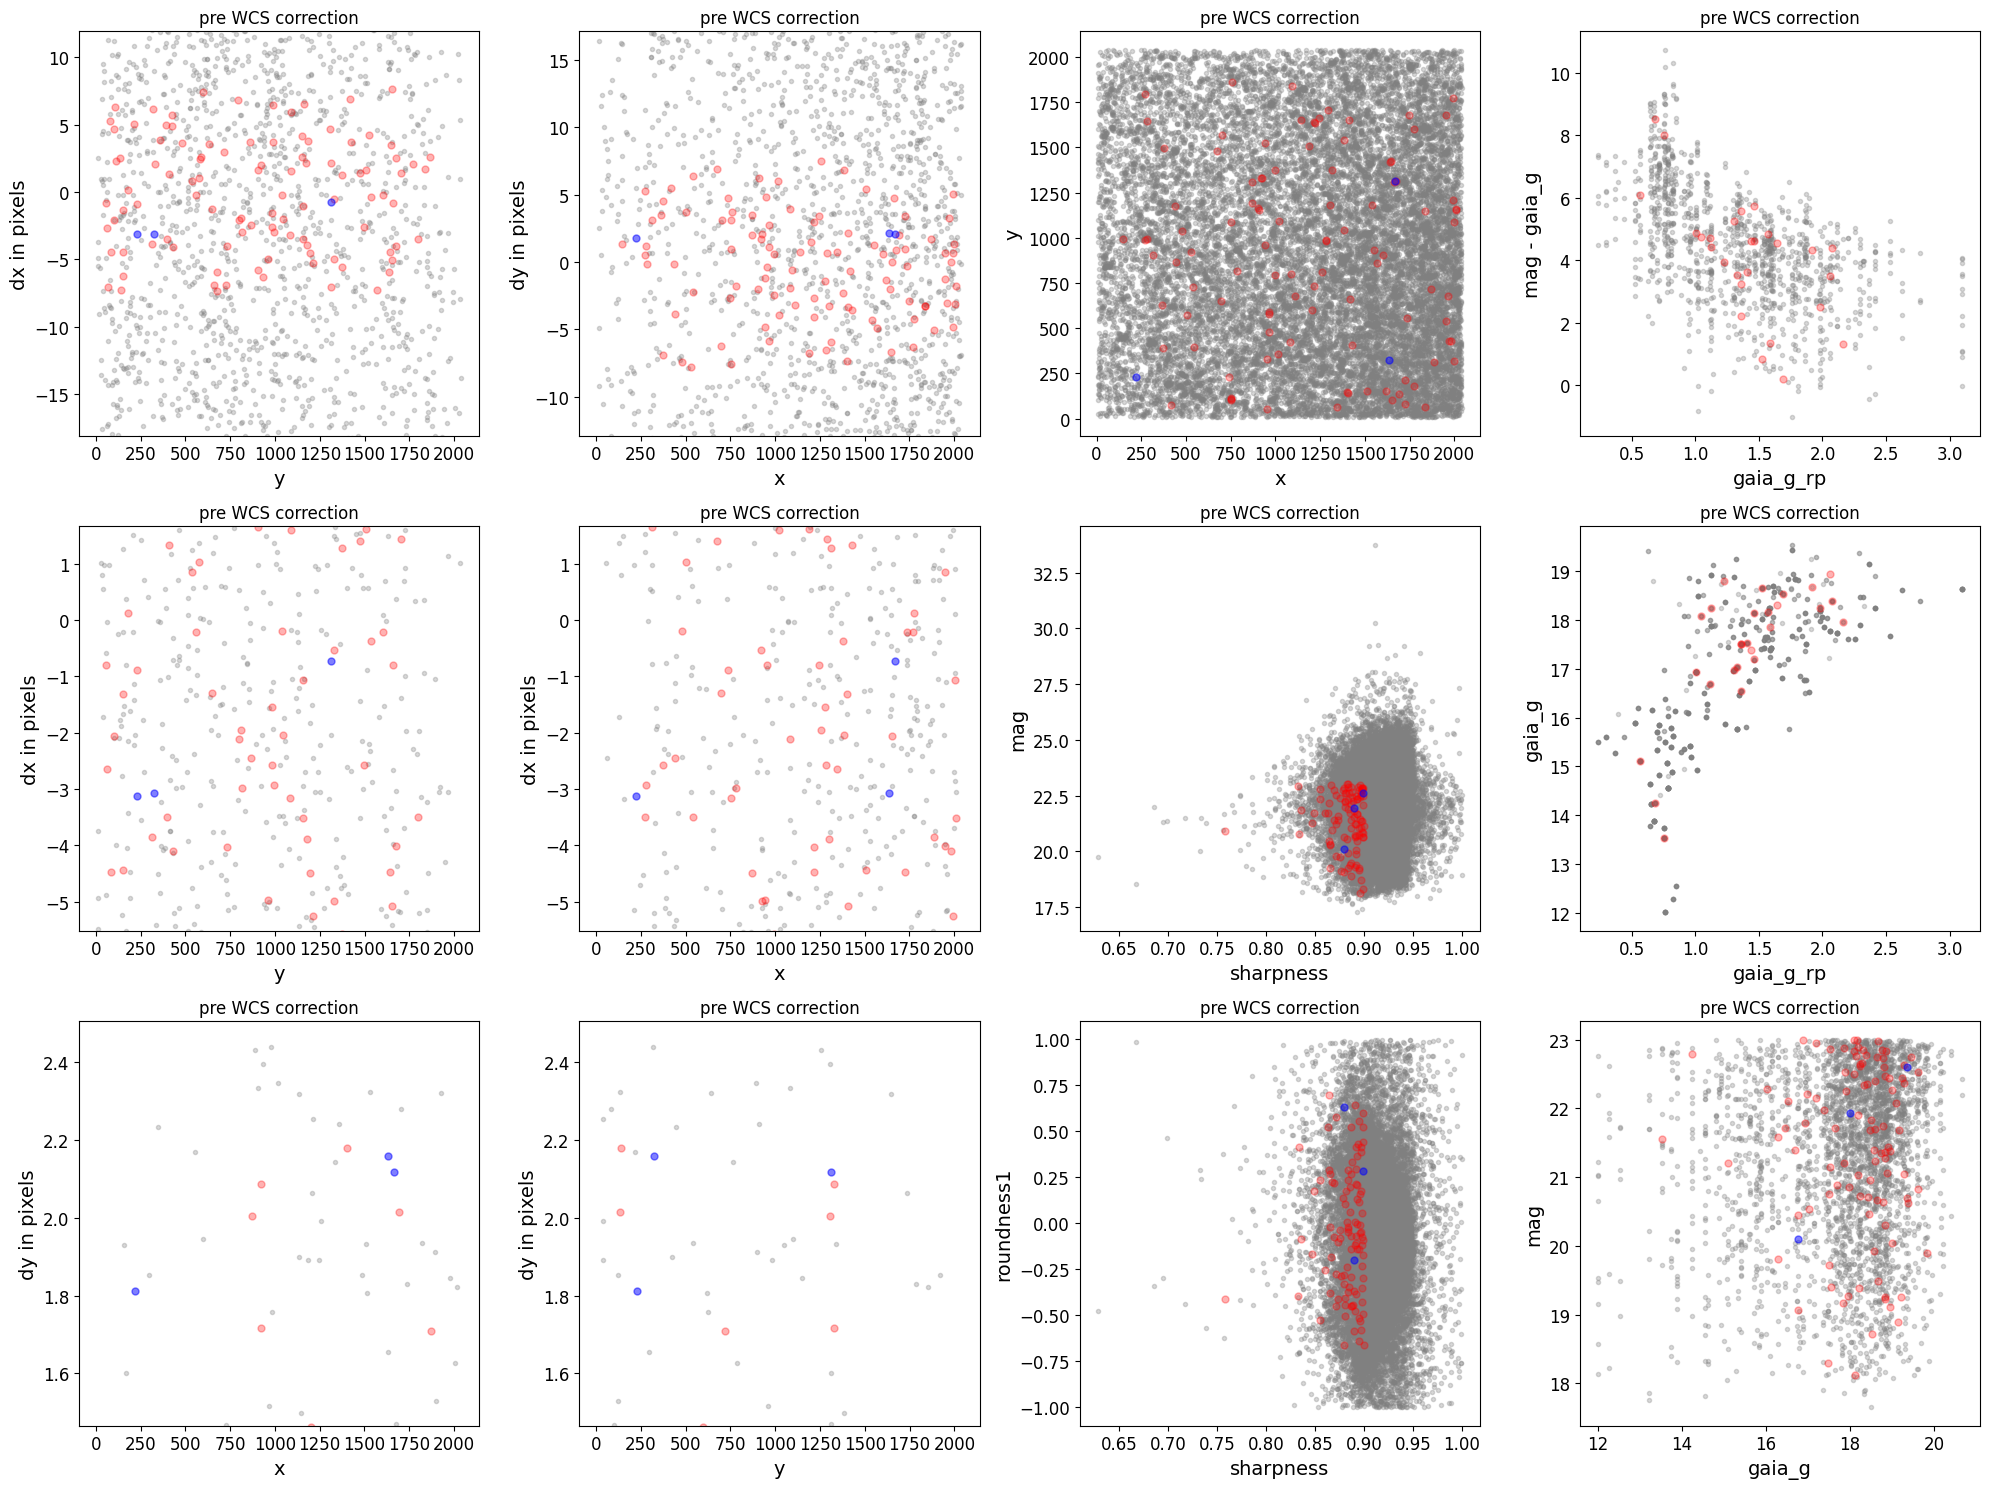

./jwstred_temp/jw01334001001_02101_00001_nrca4_jhat.fits


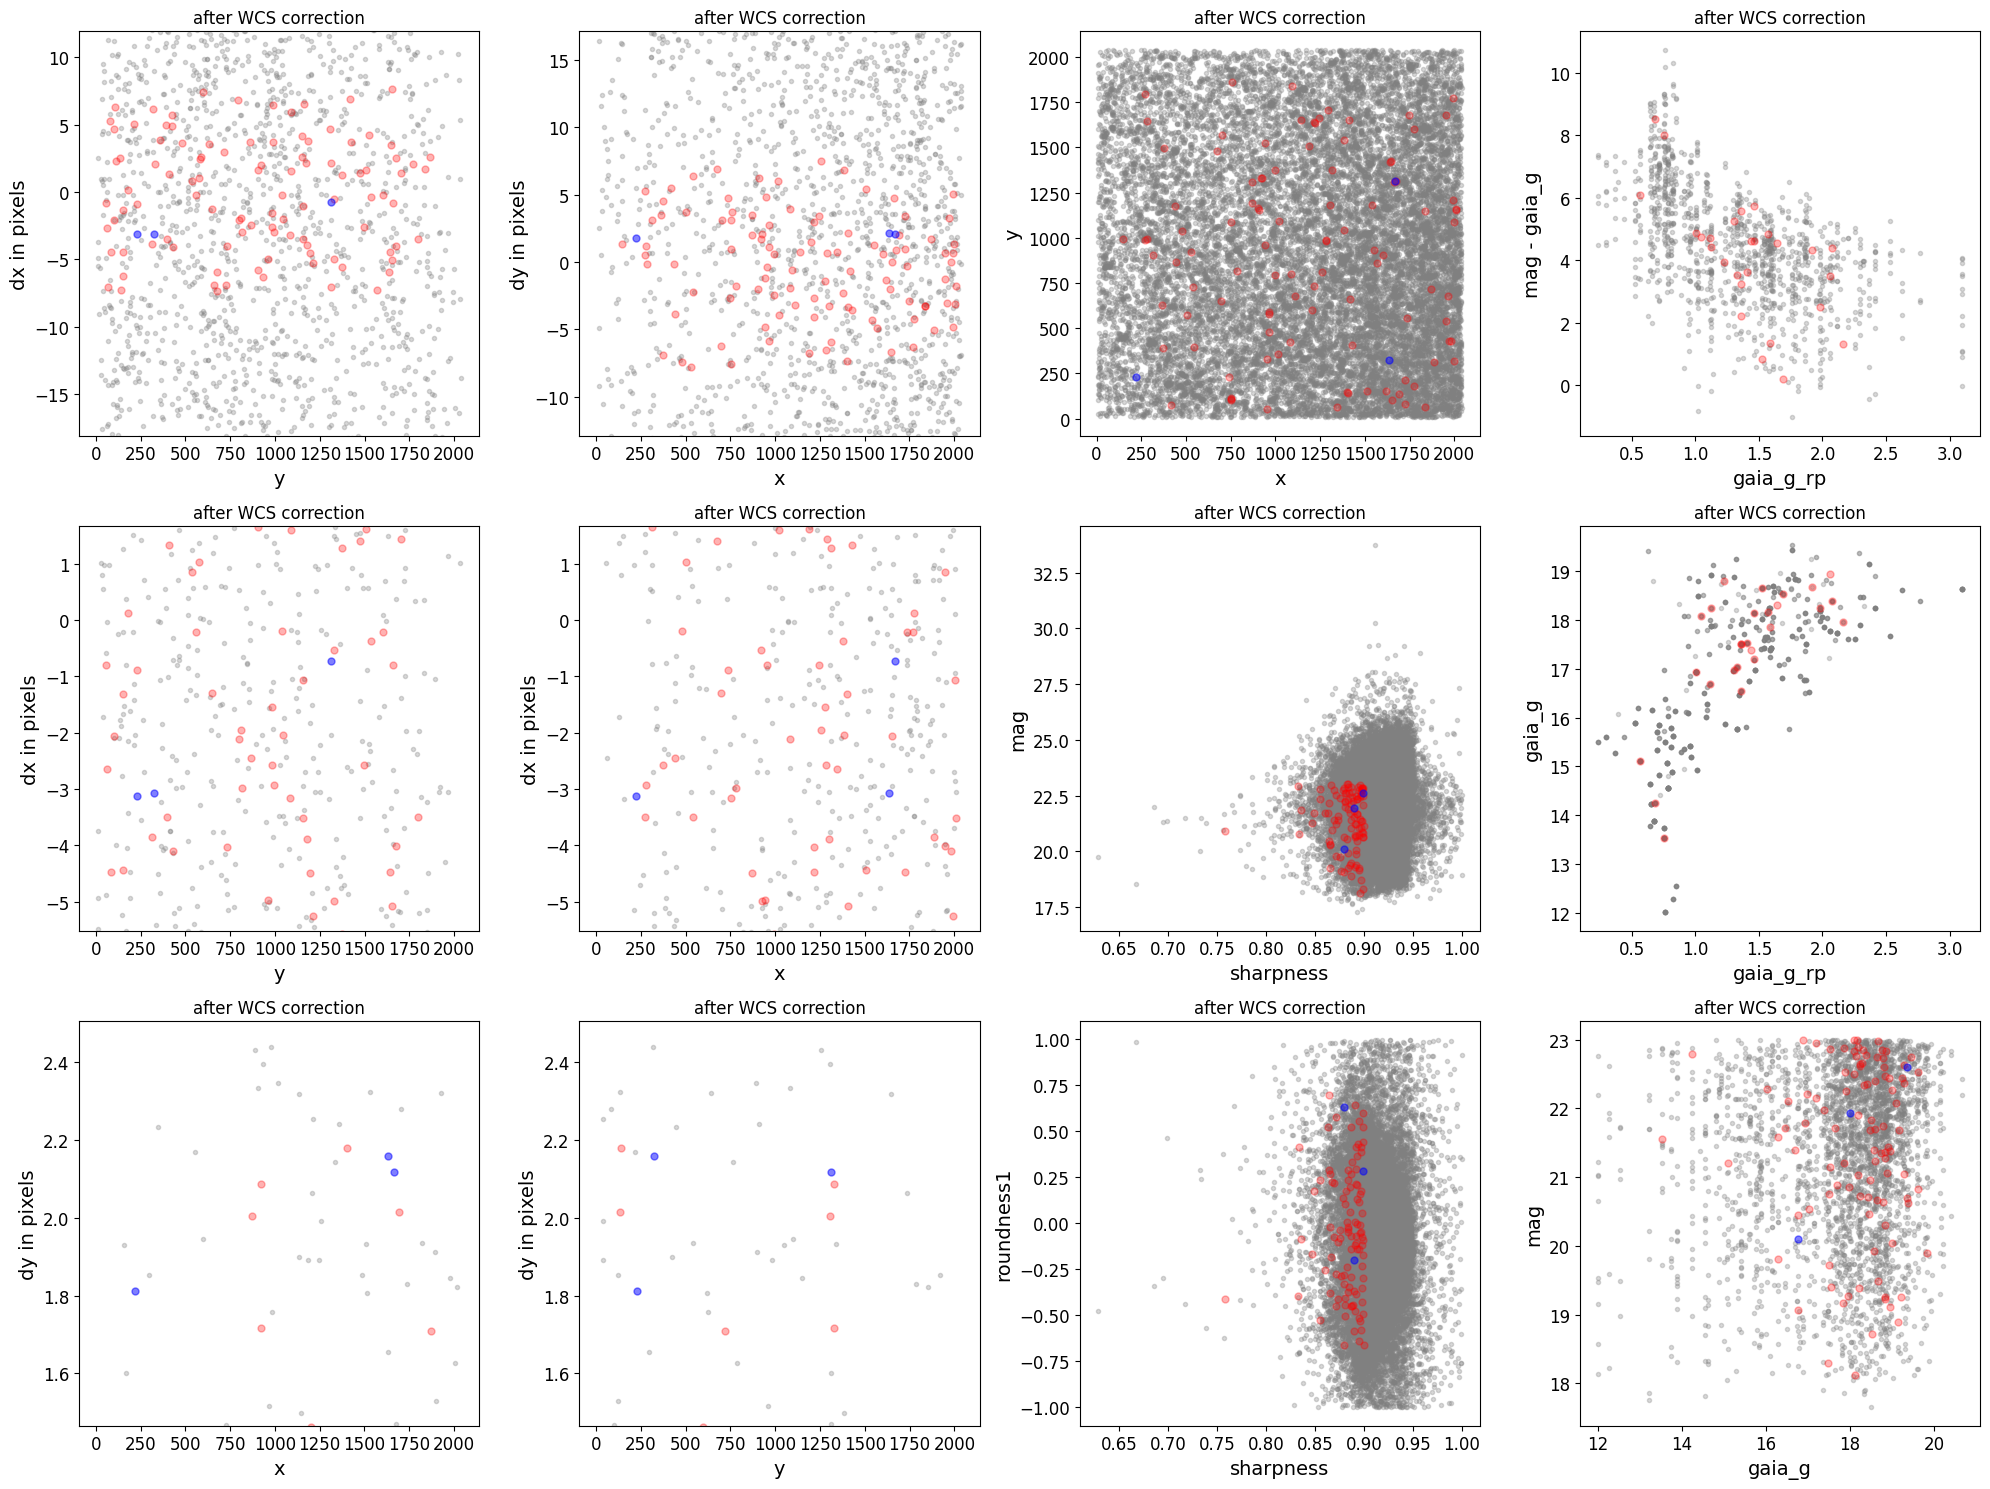

*** Note: close plots to continue!


0

In [21]:
wcs_align = st_wcs_align()

# if os.path.exists('Gaia_reference_catalog.txt'):
#     os.remove('Gaia_reference_catalog.txt')
    
wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp',
          overwrite=True,
          d2d_max=.25,
          find_stars_threshold = 3,
          showplots=2,
          refcatname='Gaia',
          histocut_order='dxdy',
          verbose = True,
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=.1,
#               Nbright = 450,
              objmag_lim =(15,23))

# aligned_image = os.path.join('jwstred_temp',os.path.basename(align_image).replace('cal.fits','jhat.fits'))
# aligned_fits = fits.open(aligned_image)
# aligned_data = fits.open(aligned_image)['SCI',1].data
# aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
# aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

# norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
# fig,axes = plt.subplots(1,2)
# axes[0].imshow(align_cutout, origin='lower',
#                       norm=norm2,cmap='gray')
# axes[1].imshow(aligned_cutout, origin='lower',
#                       norm=norm3,cmap='gray')
# axes[0].set_title('To Align')
# axes[1].set_title('Aligned')
# for i in range(2):
# 	axes[i].tick_params(labelcolor='none',axis='both',color='none')


# plt.show()

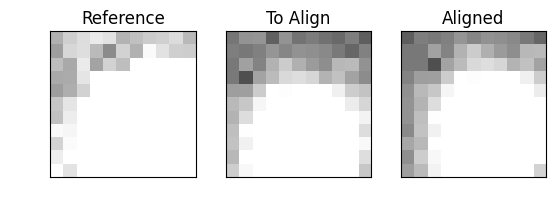

In [32]:
norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

#### Gaia xmatch

In [8]:
from jwst.datamodels import ImageModel

In [9]:
im = fits.open(align_image)

hdr = im['SCI'].header
nx = hdr['NAXIS1']
ny = hdr['NAXIS2']

image_model = ImageModel(im)

ra0,dec0 = image_model.meta.wcs(nx/2.0-1,ny/2.0-1)
coord0 = SkyCoord(ra0,dec0,unit=(u.deg, u.deg), frame='icrs')
radius_deg = []
for x in [0,nx-1]:        
    for y in [0,ny-1]:     
        ra,dec = image_model.meta.wcs(x,y)
        radius_deg.append(coord0.separation(SkyCoord(ra,dec,unit=(u.deg, u.deg), frame='icrs')).deg)
radius_deg = np.amax(radius_deg)*1.1

In [10]:
dr = 'gaiadr3'

query ="SELECT * FROM {}.gaia_source WHERE CONTAINS(POINT('ICRS',\
        {}.gaia_source.ra,{}.gaia_source.dec),\
        CIRCLE('ICRS',{},{} ,{}))=1;".format(dr,dr,dr,ra0,dec0,radius_deg)

job5 = Gaia.launch_job_async(query)
tb_gaia = job5.get_results() 
print("Number of stars:",len(tb_gaia))

2024-09-17 20:27:13,529 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 1446


In [11]:
tb_gaia

<Table length=1446>
    solution_id             DESIGNATION          ... libname_gspphot
                                                 ...                
       int64                   object            ...      object    
------------------- ---------------------------- ... ---------------
1636148068921376768 Gaia DR3 1360405022423774592 ...                
1636148068921376768 Gaia DR3 1360405400378561920 ...                
1636148068921376768 Gaia DR3 1360405400378562048 ...                
1636148068921376768 Gaia DR3 1360405400380332544 ...                
1636148068921376768 Gaia DR3 1360405400380332800 ...                
1636148068921376768 Gaia DR3 1360405022421437824 ...                
1636148068921376768 Gaia DR3 1360405022423778048 ...                
1636148068921376768 Gaia DR3 1360405022423778944 ...                
1636148068921376768 Gaia DR3 1360405091143265920 ...                
                ...                          ... ...             ...
1636148068921376768 Gaia DR3 1360405675256795008 ...                
1636148068921376768 Gaia DR3 1360405675256821120 ...                
1636148068921376768 Gaia DR3 1360405675256821248 ...                
1636148068921376768 Gaia DR3 1360405675260824832 ...                
1636148068921376768 Gaia DR3 1360405675260823808 ...                
1636148068921376768 Gaia DR3 1360405675260824320 ...                
1636148068921376768 Gaia DR3 1360405675260829440 ...                
1636148068921376768 Gaia DR3 1360405675262442496 ...                
1636148068921376768 Gaia DR3 1360405675262448256 ...

In [12]:
jhat_df = pd.read_csv(glob.glob(align_image.replace('.fits', '.phot.txt'))[0], sep = '\s+') #useful
# jhat_df[['x', 'y']].to_csv('region.csv', header = None, index = False)

In [13]:
jh_ra, jh_dec = jhat_df['ra'].to_numpy()*u.degree, jhat_df['dec'].to_numpy()*u.degree
jh_skycoord = SkyCoord(ra = jh_ra, dec = jh_dec)
ga_ra, ga_dec = np.array(tb_gaia['ra'])*u.degree, np.array(tb_gaia['dec'])*u.degree
ga_skycoord = SkyCoord(ra = ga_ra, dec = ga_dec)

In [14]:
def xmatch_common(skycrd_1, skycrd_2, dist_limit = 5.0):
    """
    crossmatch sources between two SkyCoord objects
    
    Parameters
    ------------
    
    skycrd_1 : SkyCoord
        positions of sources in catalog 1 as a SkyCoord object
    skycrd_2 : SkyCoord
        positions of sources in catalog 2 as a SkyCoord object
    dist_limit : float
        maximum distance for a match, in arcsec
        
    Returns
    ------------
    
    dist_matched_df : pd.DataFrame
        dataframe containing three columns with indices in catalog 1, 
        indices in catalog 2 and distances in arcsec respectively
    """
#     idx, d2d, d3d = jh_skycoord.match_to_catalog_sky(ga_skycoord)
    idx, d2d, d3d = skycrd_1.match_to_catalog_sky(skycrd_2)
    d = {'idx_1' : np.arange(0, len(skycrd_1)), 'idx_2' : idx, 'd2d': d2d.to(u.arcsec)}
    xmatch_df = pd.DataFrame(data=d)
    matched_df = xmatch_df.loc[xmatch_df.groupby('idx_2').d2d.idxmin()]
    dist_matched_df = matched_df[matched_df['d2d'] < dist_limit*u.arcsec]
    
    return dist_matched_df

In [16]:
dist_matched_df = xmatch_common(jh_skycoord, ga_skycoord, dist_limit=0.5)

Text(0.5, 1.0, 'jwst/gaia xmatch')

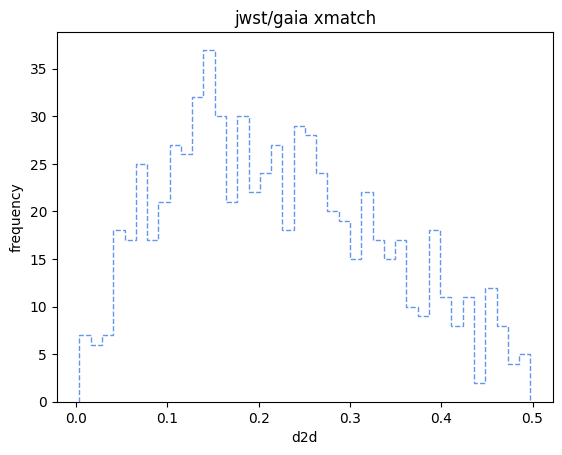

In [17]:
_ = plt.hist(dist_matched_df['d2d'], bins = 40, histtype = 'step', 
             linestyle = '--', color = 'cornflowerblue')
plt.xlabel('d2d')
plt.ylabel('frequency')
plt.title('jwst/gaia xmatch')